In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import random
%matplotlib inline
#%matplotlib notebook
plt.rcParams.update(plt.rcParamsDefault)

In [57]:
#see all available columns
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

ejections = pd.read_csv('../data/ejections.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

Text(0, 0.5, 'Height of Pitch')

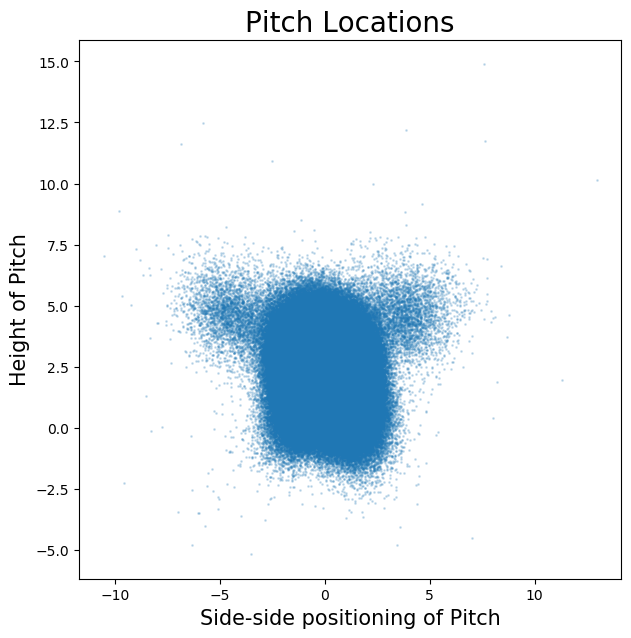

In [58]:
#plots pitch locations
plt.figure(figsize=(7,7))
plt.scatter(pitches['px'].values, pitches['pz'].values, alpha=0.2, s=1)
plt.title('Pitch Locations', size=20)
plt.xlabel('Side-side positioning of Pitch', size=15)
plt.ylabel('Height of Pitch', size=15)

In [59]:
pitches.shape

(2867154, 40)

In [60]:
atbats.shape

(740389, 11)

In [61]:
names.shape

(2218, 3)

In [62]:
ejections.shape

(761, 10)

In [63]:
games.shape

(9718, 17)

In [64]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]

#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)
pitches.reset_index(inplace=True)
#finds 'UN' in pitches and drops those rows
unknown_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(unknown_mask, inplace=True)

pitches['pitch_type'].replace('PO', 'FO', inplace=True)

In [65]:
#19,000 total rows that have atleast one NaN in them
rows_with_nans.shape

(19904,)

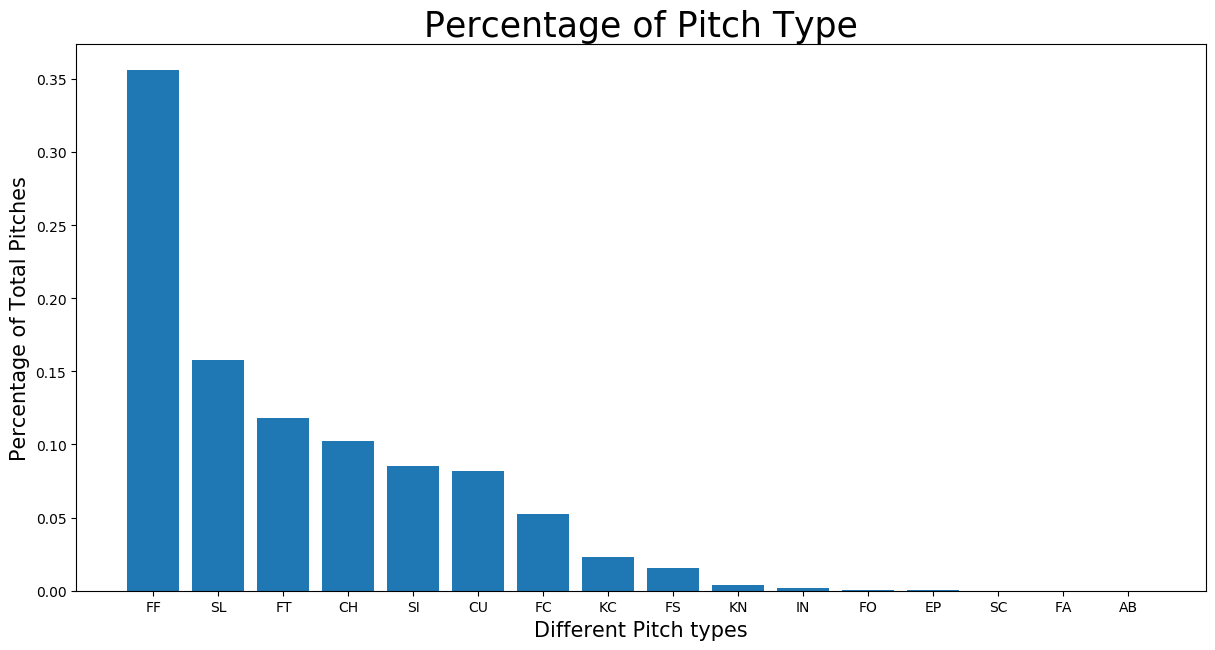

In [66]:
#x is the count of each pitch sorted
x = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].values[::-1]
#pitch is the index of different pitches
pitch = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1]
plt.figure(figsize=(12,6))
plt.bar(pitch, x/np.sum(x))
plt.tight_layout()
plt.title('Percentage of Pitch Type', size=25)
plt.ylabel('Percentage of Total Pitches', size=15)
plt.xlabel('Different Pitch types', size=15)
plt.savefig('../Graphics/pitch_types.png', dpi=100)

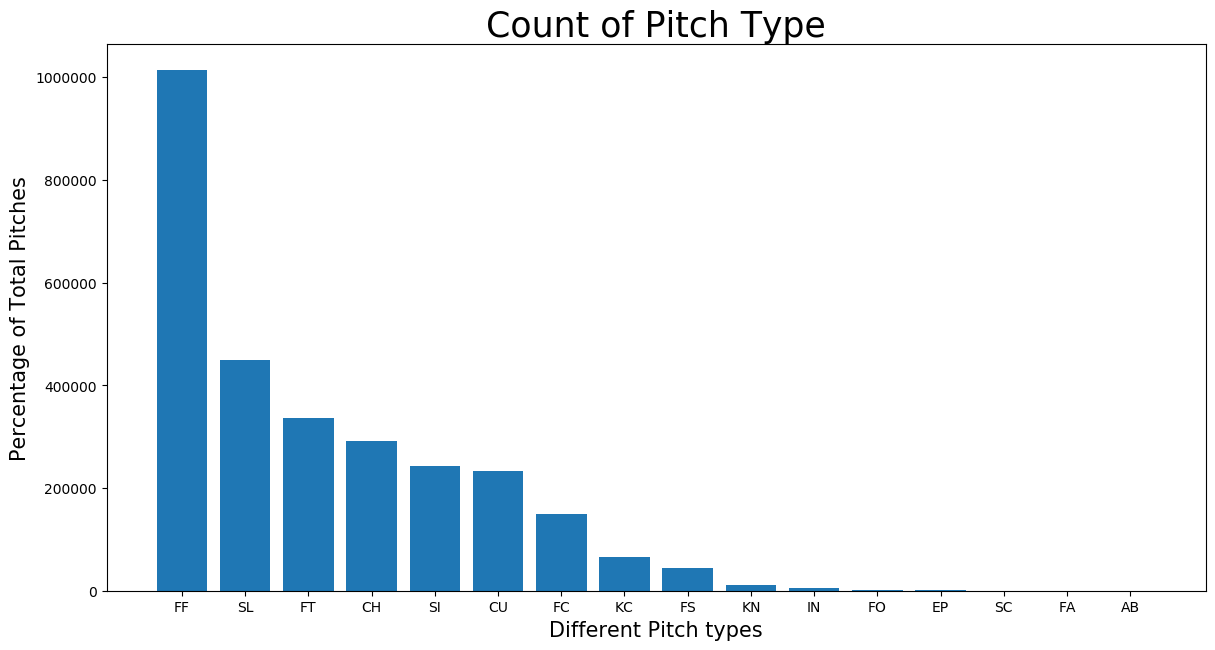

In [67]:
#x is the count of each pitch sorted
x = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].values[::-1]
#pitch is the index of different pitches
pitch = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1]
plt.figure(figsize=(12,6))
plt.bar(pitch, x)
plt.tight_layout()
plt.title('Count of Pitch Type', size=25)
plt.ylabel('Percentage of Total Pitches', size=15)
plt.xlabel('Different Pitch types', size=15)
plt.savefig('../Graphics/pitch_types_count.png', dpi=100)

In [68]:
#pca need to plot these compositions with every different pitch type and look to see a difference
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
pca_comps = pca2.fit_transform(pitches.iloc[:, :8])

In [69]:
#top 6 most common pitches
top_6_labels = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1][:6]

#first feature of pca with 2 components
x = pca_comps[:, 0]
#second feature of pac with 2 components
y = pca_comps[:, 1]
#labels of each pitch type for each row in pitches
pitch_type = pitches['pitch_type'].values

FF
SL
FT
CH
SI
CU


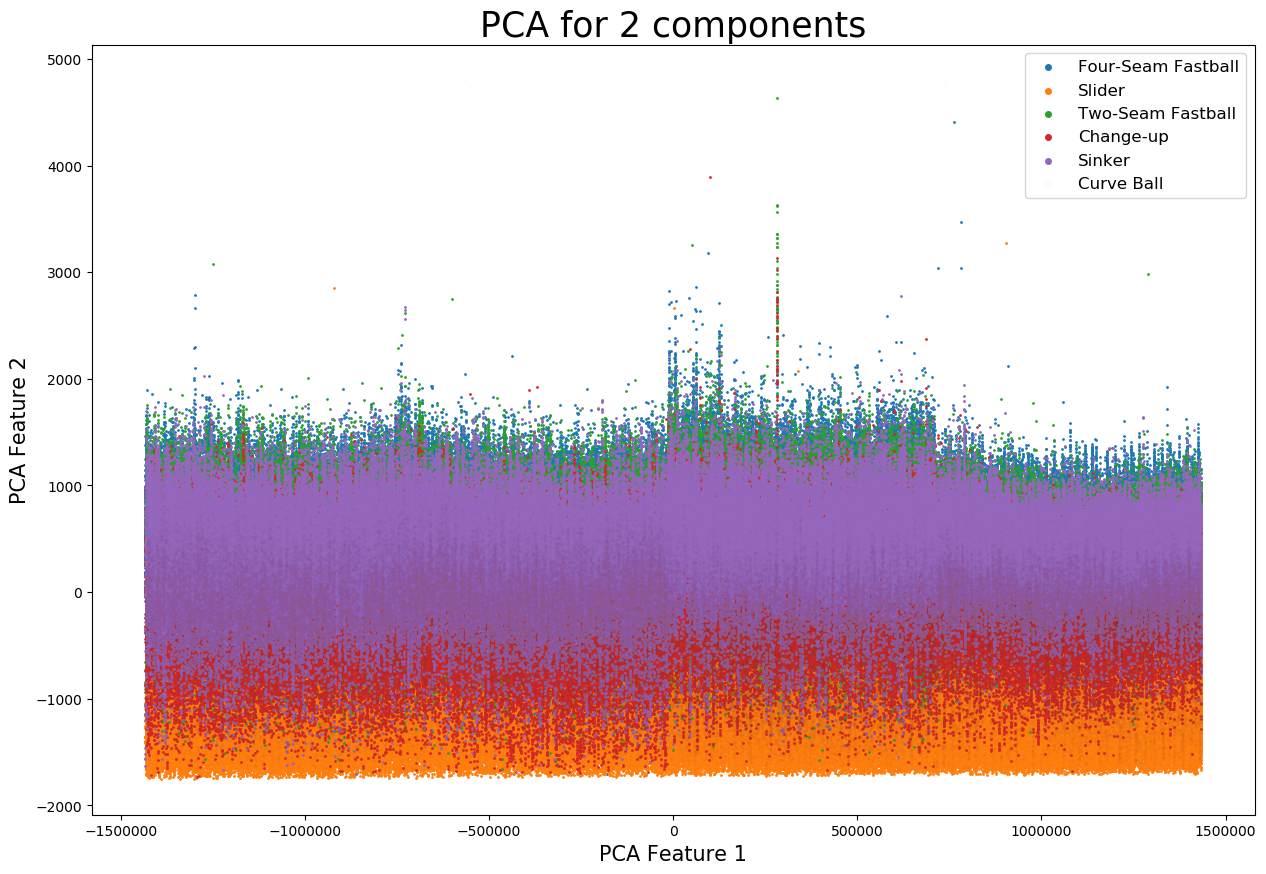

In [70]:
#dictionary to have nice plotting of types of pitches
dic = {'FF':'Four-Seam Fastball', 'SL': 'Slider', 'FT': 'Two-Seam Fastball', 'CH': 'Change-up', 'SI': 'Sinker', 'CU': 'Curve Ball'}


plt.figure(figsize=(15,10))
for label in top_6_labels:
    line = plt.scatter(x[pitch_type == label], y[pitch_type == label], label=label, s=1)
    print(label)
plt.title('PCA for 2 components', size=25)
line.set_alpha(0.02)
plt.xlabel('PCA Feature 1', size=15)
plt.ylabel('PCA Feature 2', size=15)
#plt.ylim(-5, 15)
#plt.xlim(-1800, 2500)
#plt.legend doesnt want to work??
plt.legend(loc=1, markerscale=4, fontsize='large', labels=dic.values())
plt.savefig('../Graphics/PCA_2comps.png', dpi=100);

## Takeaways from EDA
Predicting the pitch type based on the count, the pitcher, (the previous pitches??), the score, runners on 1st, 2nd, 3rd, the number of pitches thrown so far, pitcher left handed/right handed, the batter handedness, inning, so much more...

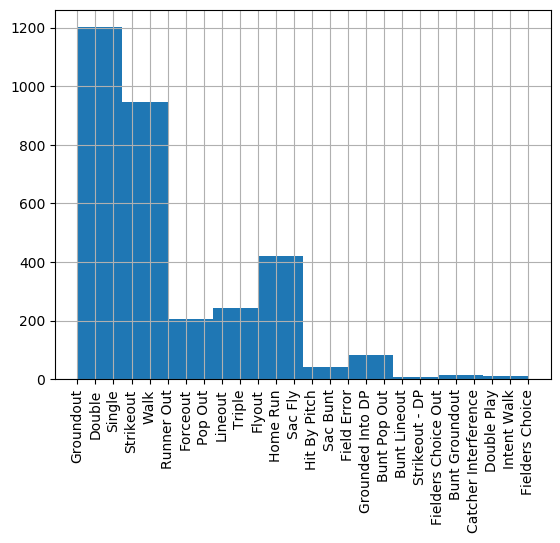

In [71]:
atbats[(atbats['pitcher_id'] == 452657)]['event'].hist()
plt.xticks(rotation=90);

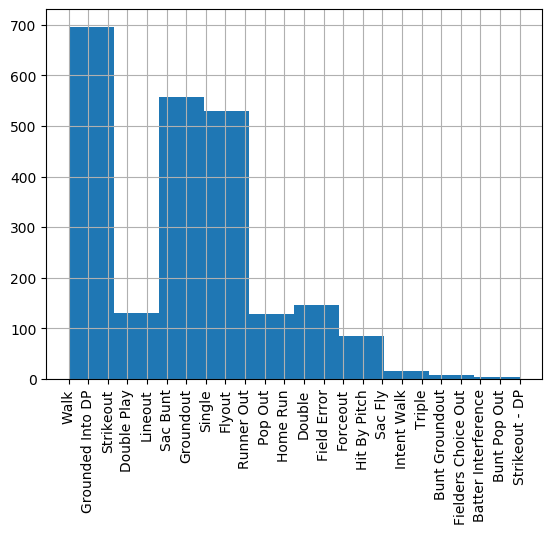

In [72]:
atbats[(atbats['pitcher_id'] == 448802)]['event'].hist()
plt.xticks(rotation=90);

In [73]:
#this pitcher has seen every batter on average of 6 times each 
atbats[(atbats['pitcher_id'] == 452657)] .groupby(['pitcher_id', 'batter_id']).count().mean()

ab_id       6.203523
event       6.203523
g_id        6.203523
inning      6.203523
o           6.203523
p_score     6.203523
p_throws    6.203523
stand       6.203523
top         6.203523
dtype: float64

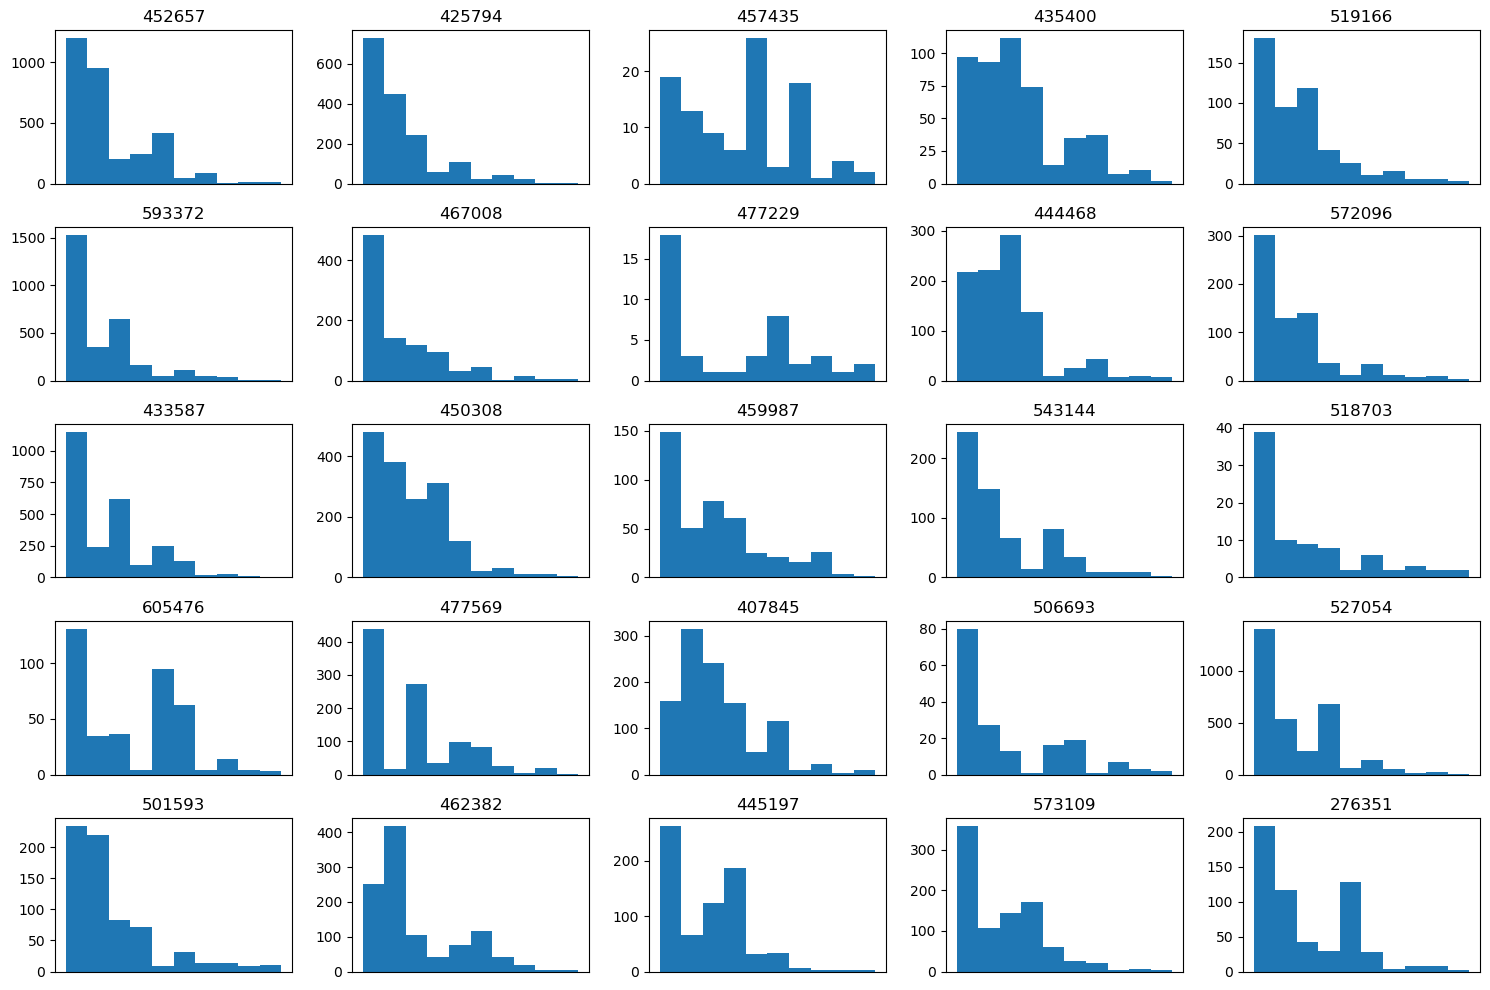

In [74]:
#looks at different pitchers and the results of all of the batters they see
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(atbats[atbats['pitcher_id'] == pitcher]['event'].values)
    ax.set_xticks([])
    ax.set_title(pitcher)
    
plt.tight_layout()
    

In [75]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

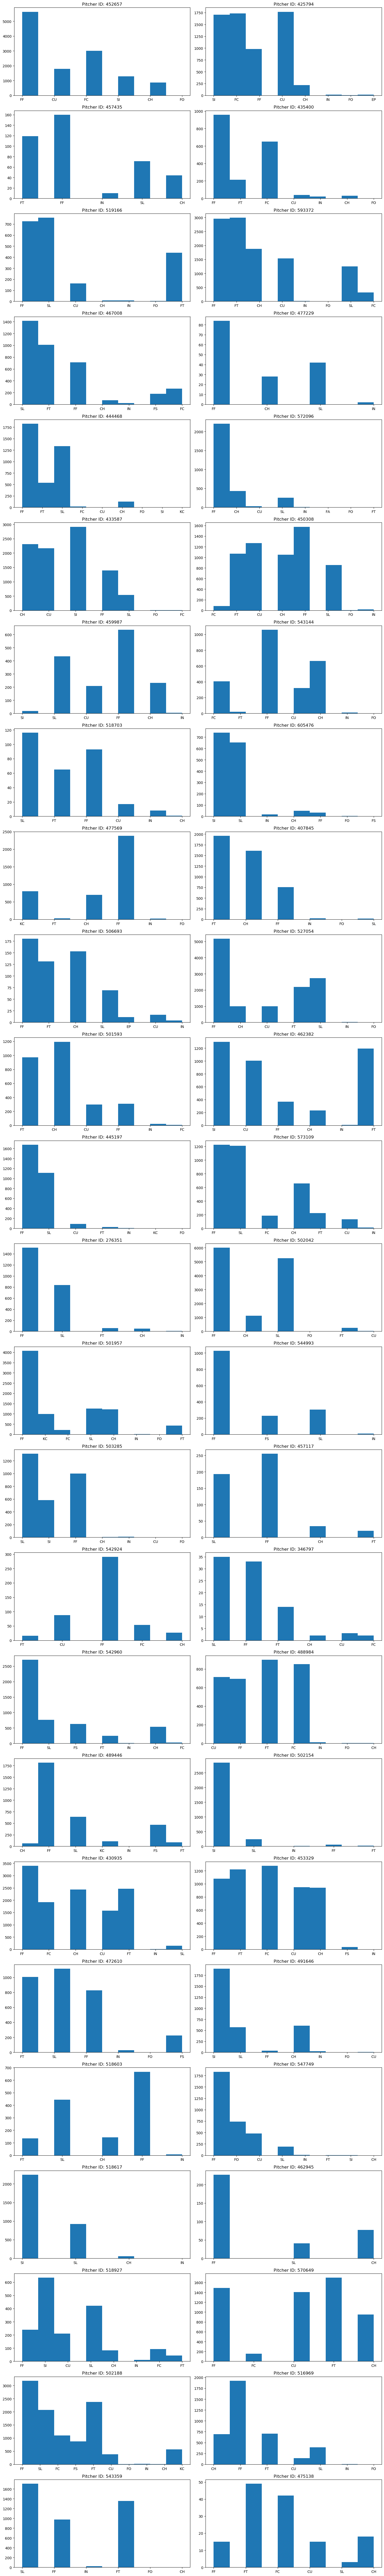

In [76]:
#looks at first 50 pitchers and observes their pitch types
fig, ax = plt.subplots(25, 2, figsize=(15, 100))
no_nan_df = game_sit.replace(np.nan, 'None')
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(no_nan_df[no_nan_df['pitcher_id'] == pitcher]['pitch_type'])
    #ax.set_xticks()
    ax.set_title('Pitcher ID: {}'.format(pitcher))
    
plt.tight_layout() 

Text(0, 0.5, 'Percent of Pitches')

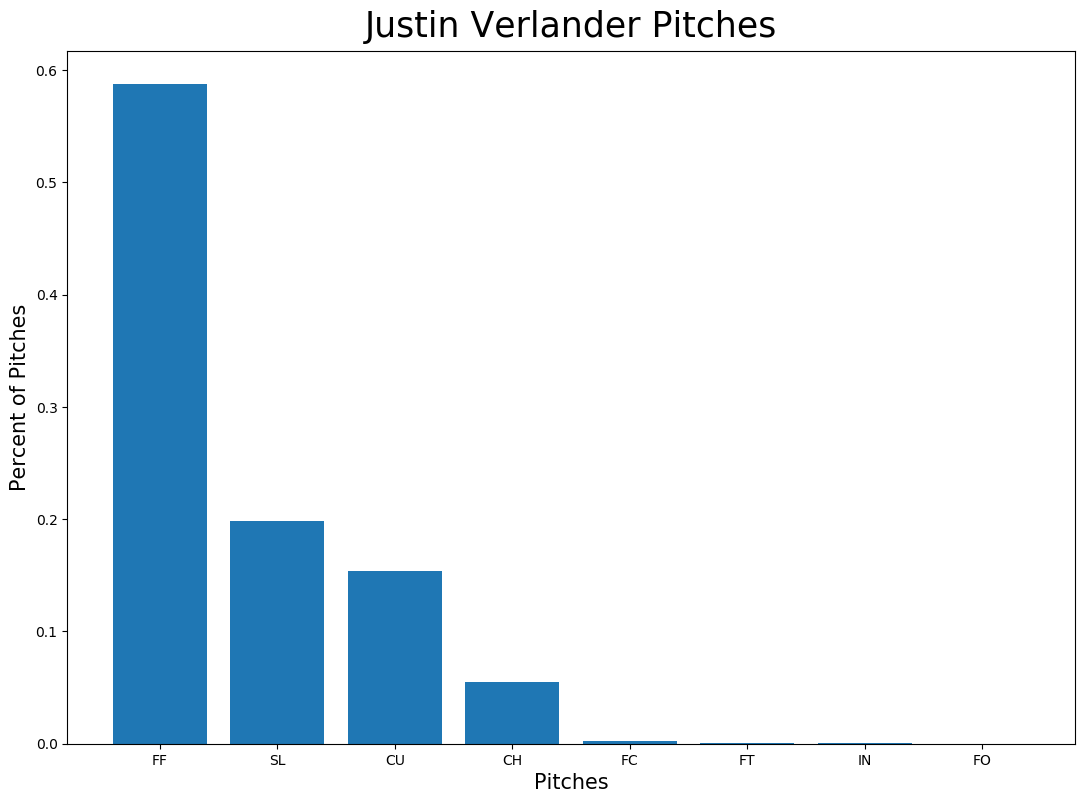

In [90]:
#looks at one pitchers distribution of pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('pitch_type').count().sort_values('ab_id', ascending=False)['ab_id'].values
pitch_type = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('pitch_type').count()[['ab_id']].sort_values('ab_id', ascending=False).index
plt.figure(figsize=(13,9))
plt.bar(pitch_type, nums/np.sum(nums))
plt.title('Justin Verlander Pitches', size=25, pad=10)
plt.xlabel('Pitches', size=15)
plt.ylabel('Percent of Pitches', size=15)
#plt.savefig('../Graphics/Verlander_pitches.png', dpi=100);

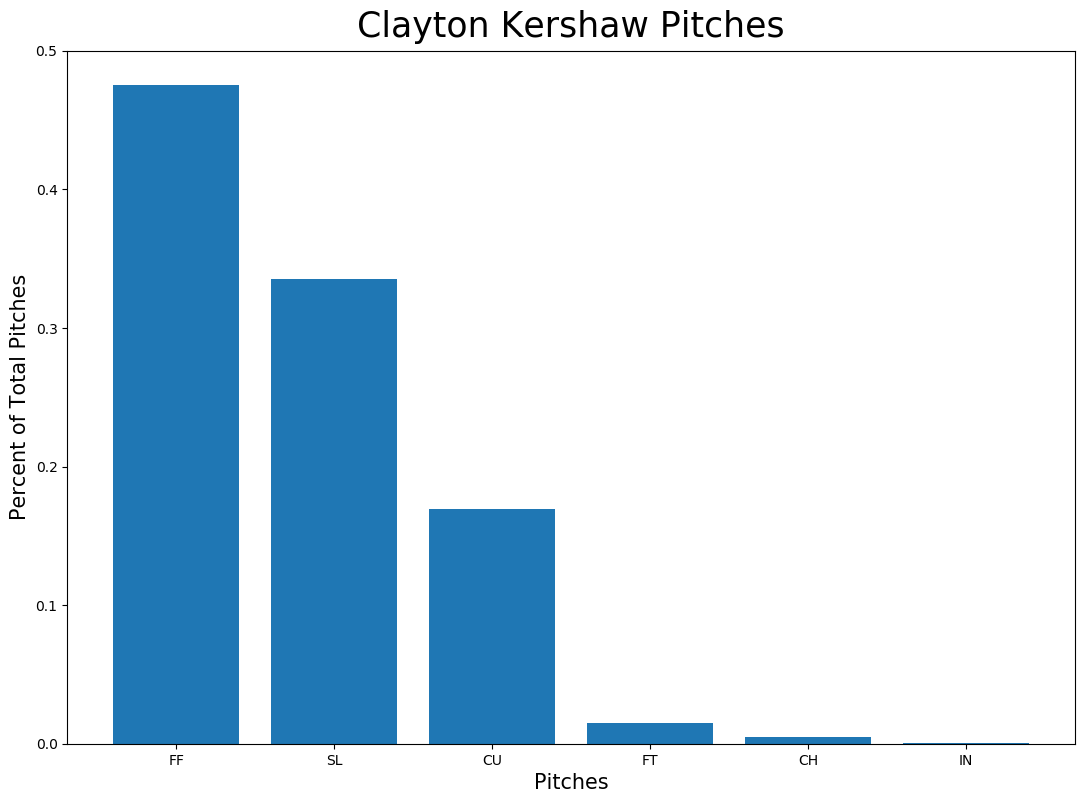

In [93]:
#Kershaw pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 477132].groupby('pitch_type').count().sort_values('ab_id', ascending=False)['ab_id'].values
pitch_type = no_nan_df[no_nan_df['pitcher_id'] == 477132].groupby('pitch_type').count()[['ab_id']].sort_values('ab_id', ascending=False).index
plt.figure(figsize=(13,9))
plt.bar(pitch_type, nums / np.sum(nums))
plt.title('Clayton Kershaw Pitches', size=25, pad=10)
plt.xlabel('Pitches', size=15)
plt.ylabel('Percent of Total Pitches', size=15)
plt.ylim(0, 0.5)
plt.savefig('../Graphics/Kershaw_pitches.png', dpi=100);

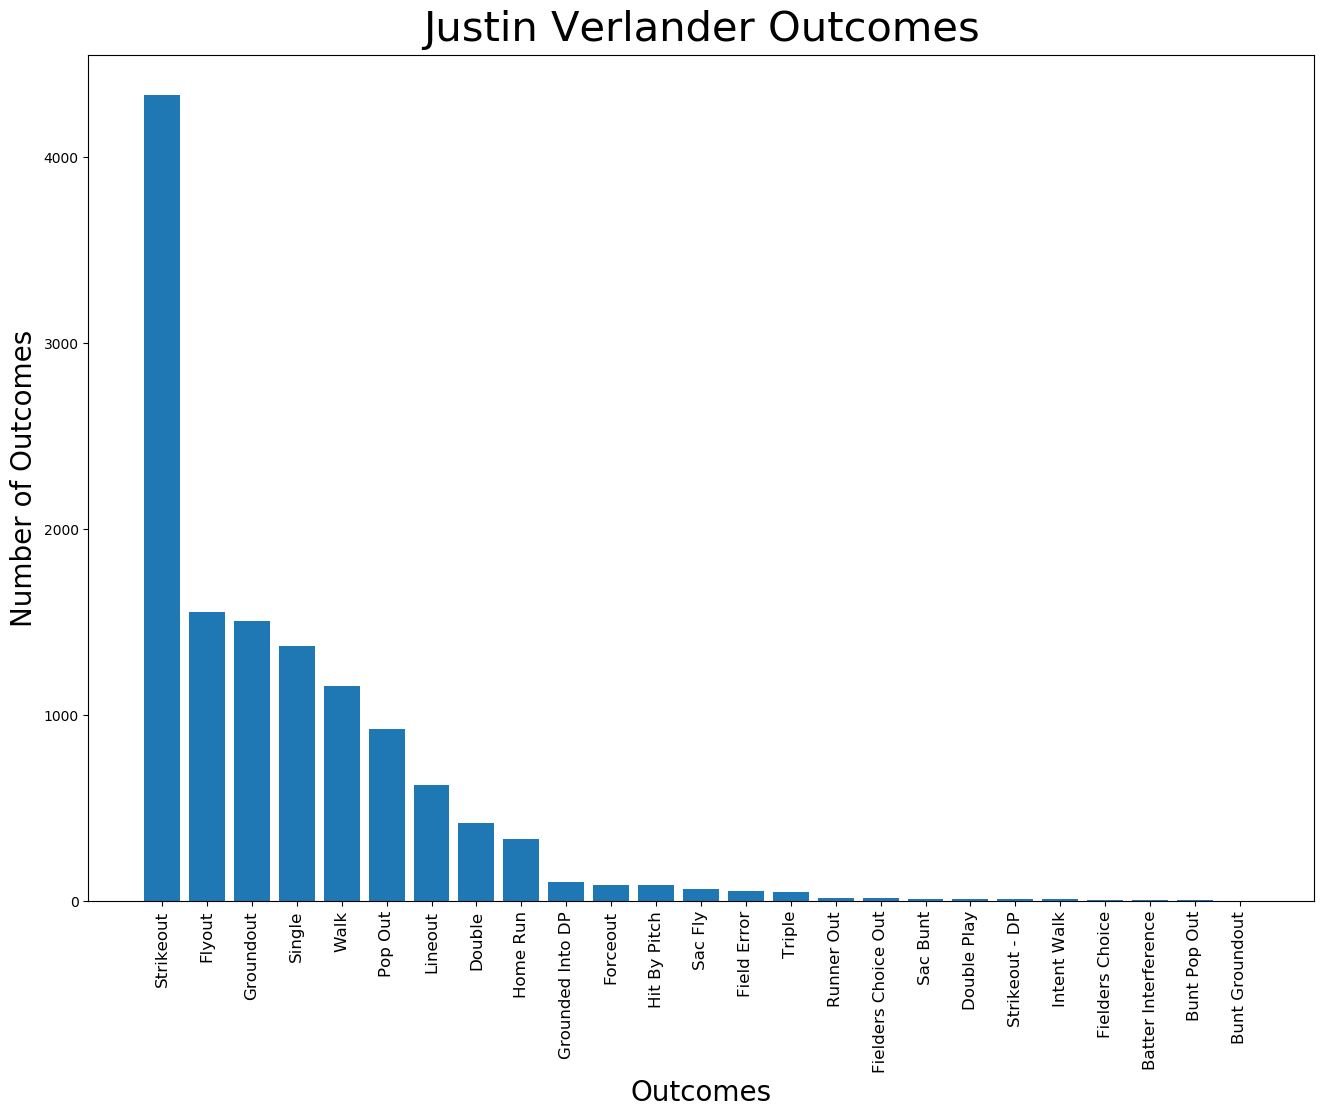

In [79]:
#distribution of outcomes of pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('event').count().sort_values('ab_id', ascending=False)['ab_id'].values
outcome = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('event').count().sort_values('ab_id', ascending=False)['ab_id'].index

plt.figure(figsize=(13,9))
plt.bar(outcome, nums)
plt.tight_layout()
plt.ylabel('Number of Outcomes', size=20)
plt.xlabel('Outcomes', size=20)
plt.title('Justin Verlander Outcomes', size=30, pad=10)
plt.xticks(rotation=90, size=12);


In [80]:
#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_play_df = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [81]:
#grabs columns that make sense
final_play_df = final_play_df[['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id', 'inning', 'p_score', 'p_throws', 'batter_stand', 'top', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pitch_type']]
#replaces R and L with 1's and 0's
final_play_df.replace({'R': 1, 'L': 0}, inplace=True)

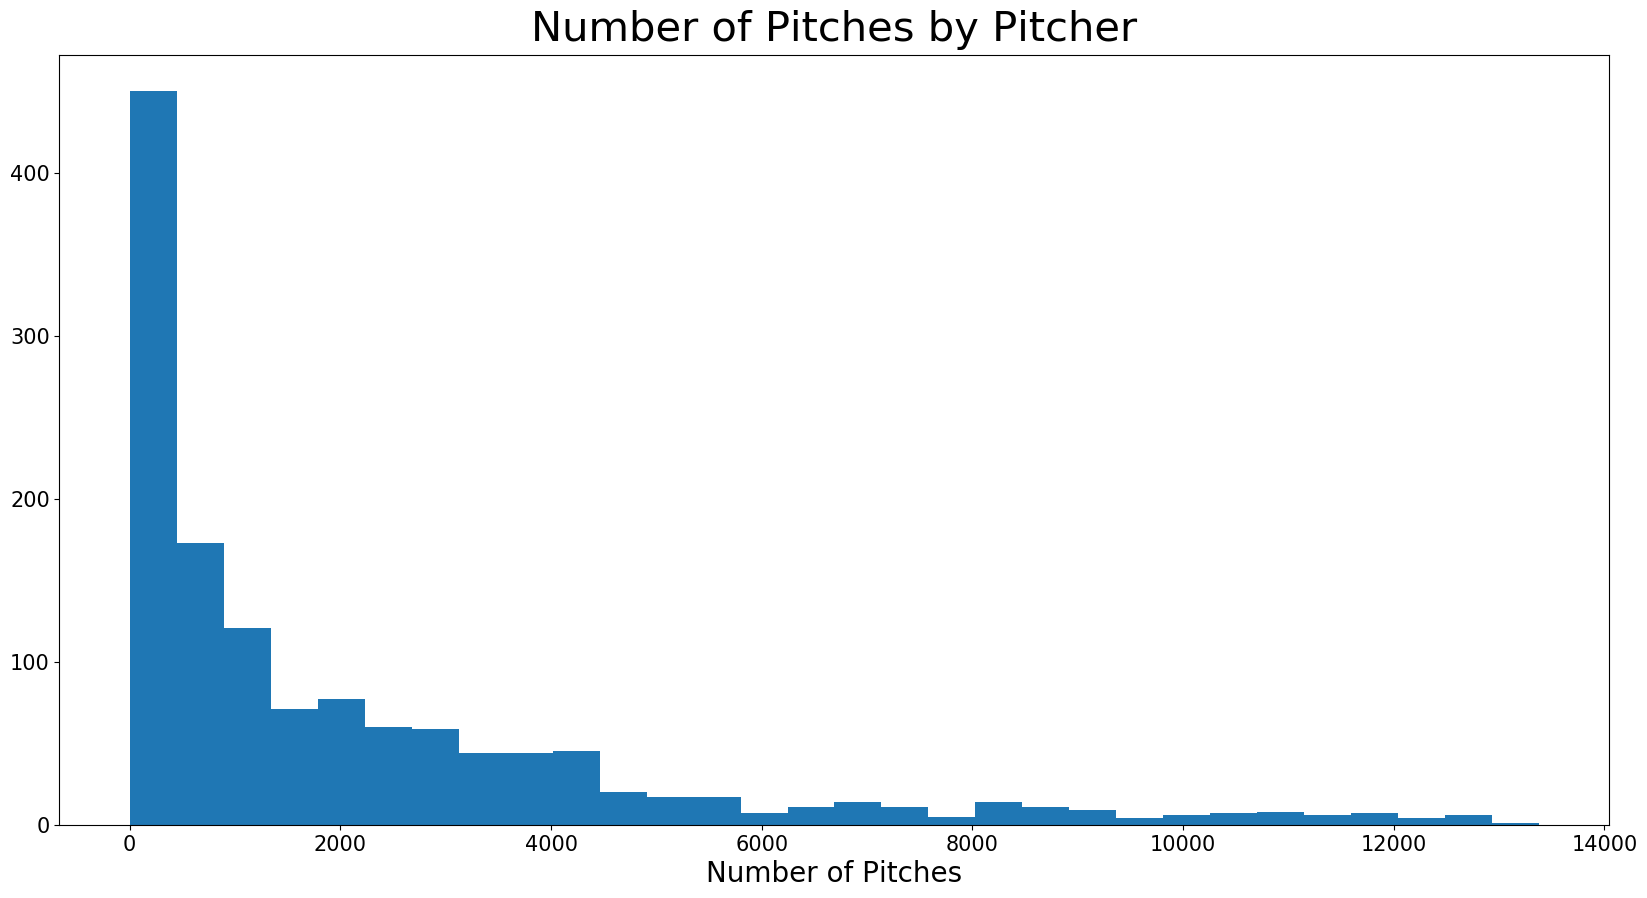

In [88]:

index = final_play_df.groupby('pitcher_name').count().iloc[:, 0].index
nums = final_play_df.groupby('pitcher_name').count().iloc[:, 0].values
mean_nums = np.mean(nums)

plt.figure(figsize=(20,10))
plt.title('Number of Pitches by Pitcher', size=30, pad=10)
plt.hist(nums, bins=30)
#plt.axhline(mean_nums, c='b', label='Average number of Pitches')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Number of Pitches', size=20)
plt.savefig('../Graphics/num_pitches_per_pitcher.png', dpi=100)

In [35]:
pitch_names = pd.get_dummies(final_play_df['pitcher_name'])

In [36]:
#takes a long time to run
#merges class_modeling with the new pitch names, drops the redundant columns 
#drops one of the pitchers from the df using random.choice 
df = final_play_df.merge(pitch_names, left_index=True, right_index=True).drop(columns=['ab_id', 'pitcher_name', 'batter_name', 'batter_id', 'pitcher_id', 'game_id', random.choice(pitch_names.columns)])

## Sampling each class 

Need to sample each pitch type of only 200,000 samples each. 

In [39]:
def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    acc_scores = []
    #f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        acc_scores.append(model.score(X_test, y_test))
        
        #change micro to weighted?
        #f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))

    #print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    #print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return np.mean(acc_scores) 

In [33]:
#moving to Logistic regression for base model
from sklearn.linear_model import LogisticRegression

### Pitches that have over 200,000 are:

FF

SL

FT

CH

SI

CU

In [37]:
ff = np.where(df['pitch_type'] == 'FF')[0]
sl = np.where(df['pitch_type'] == 'SL')[0]
ft = np.where(df['pitch_type'] == 'FT')[0]
ch = np.where(df['pitch_type'] == 'CH')[0]
si = np.where(df['pitch_type'] == 'SI')[0]
cu = np.where(df['pitch_type'] == 'CU')[0]


In [38]:
ff_index = random.choices(ff, k=200000)
sl_index = random.choices(sl, k=200000)
ft_index = random.choices(ft, k=200000)
ch_index = random.choices(ch, k=200000)
si_index = random.choices(si, k=200000)
cu_index = random.choices(cu, k=200000)

In [39]:
all_indicies = np.append([ff_index, sl_index, ch_index, si_index, cu_index], ft_index)

In [40]:
resampled_df = df.iloc[all_indicies, :]

In [41]:
resampled_df.reset_index(inplace=True)

In [42]:
resampled_df.drop(columns='index', inplace=True)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(resampled_df.drop(columns='pitch_type'), resampled_df['pitch_type'], test_size=0.50, random_state=42, stratify=resampled_df['pitch_type'])

In [76]:
X = X_train2
y = y_train2

kf = KFold(n_splits=2, shuffle=True)  # almost always use shuffle=True
acc_scores = []
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    
    acc_scores.append(model.score(X_test, y_test))


In [86]:
#logistic regression accuracy score
#very low for an accuracy score
np.mean(acc_scores)

0.44894666666666666

In [80]:
#can we get the probability of each class on the training set?
predictions = model.predict_proba(X_train)

In [85]:
#one example of the predict proba
#very interesting to note that in this example sinker had the highest probability
predictions[3]

array([0.03856789, 0.01050831, 0.01851017, 0.00962448, 0.88420002,
       0.03858913])

In [82]:
model.classes_

array(['CH', 'CU', 'FF', 'FT', 'SI', 'SL'], dtype=object)

In [106]:
X = X_train2
y = y_train2

kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
acc_scores = []
model = RandomForestClassifier()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    
    acc_scores.append(model.score(X_test, y_test))


In [107]:
#randomforest did 10% better than Logistic regression, but still a very low score
acc_scores

[0.5566916666666667,
 0.5591833333333334,
 0.5576416666666667,
 0.5600666666666667,
 0.5590166666666667]

In [109]:
X = X_train2
y = y_train2

kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
acc_scores = []
model = GradientBoostingClassifier()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    
    acc_scores.append(model.score(X_test, y_test))


In [111]:
#gradient boosting classifier did even worse than Logistic Regression 
acc_scores

[0.41039166666666665,
 0.4073333333333333,
 0.4074583333333333,
 0.4099333333333333,
 0.40649166666666664]

In [123]:
#save gradient boosting classifier 
import pickle
filename = '../Models/gb_model.sav'
pickle.dump(model, open(filename, 'wb'))

#how to use model later again
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [115]:
y_pred = model.predict(X_test2)

In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [116]:
confusion_matrix(y_test2, y_pred, normalize='pred')

array([[0.3287508 , 0.12589487, 0.11887517, 0.1385935 , 0.11842224,
        0.09999307],
       [0.15185804, 0.39055144, 0.11038859, 0.10311651, 0.05749952,
        0.1507361 ],
       [0.16985681, 0.16187251, 0.35478335, 0.09880465, 0.02393668,
        0.18908789],
       [0.15843574, 0.12719553, 0.17847021, 0.50622228, 0.00146709,
        0.13389735],
       [0.08379687, 0.08742341, 0.10894004, 0.02088416, 0.70862879,
        0.10480594],
       [0.10730174, 0.10706224, 0.12854264, 0.13237889, 0.09004569,
        0.32147964]])

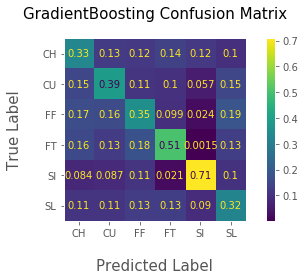

In [125]:
fig, ax = plt.subplots(1)
conf = plot_confusion_matrix(model, X_test2, y_test2, normalize='pred', labels=model.classes_, ax=ax)
conf.ax_.grid(False)
conf.ax_.set_title('GradientBoosting Confusion Matrix', size=15, pad=20)
conf.ax_.set_xlabel('Predicted Label', size=15, labelpad=20)
conf.ax_.set_ylabel('True Label', size=15, labelpad=20)
plt.tight_layout()
plt.savefig('../Graphics/GB_conf_matrix.png', dpi=100)

In [129]:
#reshape the features
features = model.feature_importances_.reshape(-1, 1)
#create dataframe grouping each feat importance with the corresponding feature (column)
feature_im_df = pd.DataFrame(data=features, index=X_train2.columns)
#sort by 0th column inplace for plotting purposes
feature_im_df.sort_values(by=0, inplace=True)


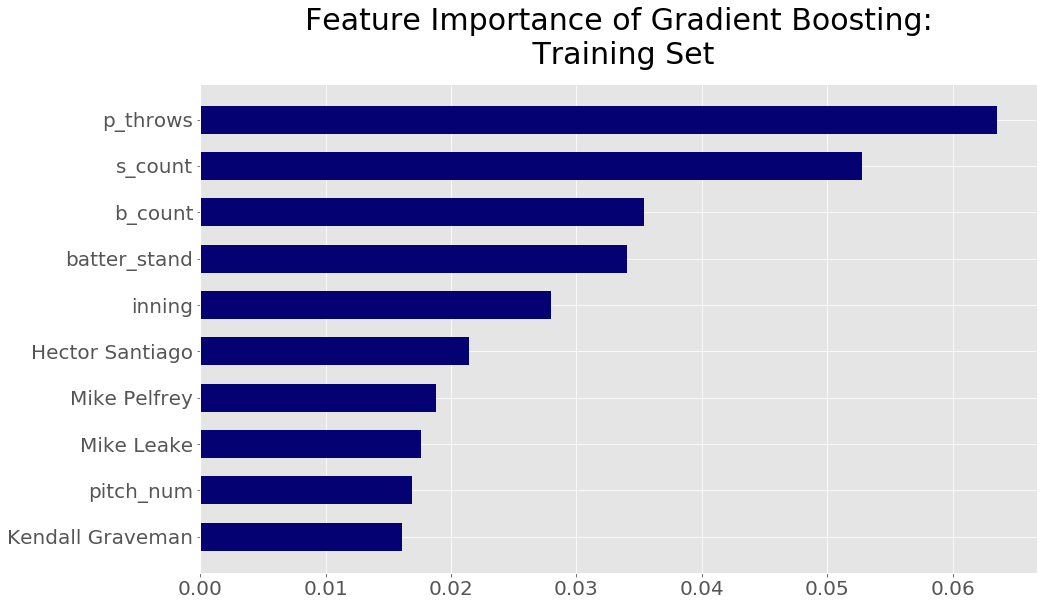

In [141]:
#plots permutation importance for gbc training set 
plt.figure(figsize=(15,9))
plt.barh(feature_im_df.index[:10][::-1], feature_im_df.iloc[:10, 0].values[::-1], height=0.6, color='xkcd:deep blue')
plt.yticks(size=20)

plt.xticks(size=20)
plt.title('Feature Importance of Gradient Boosting:\n Training Set', size=30, pad=20)
plt.savefig('../Graphics/perm_imptnt_GB.png', dpi=100, bbox_inches='tight')



### Next path is to try tensorflow in keras 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [49]:
ff = np.where(df['pitch_type'] == 'FF')[0]
sl = np.where(df['pitch_type'] == 'SL')[0]
ft = np.where(df['pitch_type'] == 'FT')[0]
ch = np.where(df['pitch_type'] == 'CH')[0]
si = np.where(df['pitch_type'] == 'SI')[0]
cu = np.where(df['pitch_type'] == 'CU')[0]


ff_index = random.choices(ff, k=50000)
sl_index = random.choices(sl, k=50000)
ft_index = random.choices(ft, k=50000)
ch_index = random.choices(ch, k=50000)
si_index = random.choices(si, k=50000)
cu_index = random.choices(cu, k=50000)

all_indicies = np.append([ff_index, sl_index, ch_index, si_index, cu_index], ft_index)

resampled_df = df.iloc[all_indicies, :]

resampled_df.reset_index(inplace=True)

resampled_df.drop(columns='index', inplace=True)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

X_train2, X_test2, y_train2, y_test2 = train_test_split(resampled_df.drop(columns='pitch_type'), resampled_df['pitch_type'], test_size=0.50, random_state=42, stratify=resampled_df['pitch_type'])

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
model_nn = keras.models.Sequential()

model_nn.add(keras.layers.Dense(units=36, input_dim=1341, activation='relu'))
#model_nn.add(keras.layers.Dropout(rate=0.2)) 
model_nn.add(keras.layers.Dense(units=1024, activation='relu'))
model_nn.add(keras.layers.Dropout(rate=0.2)) 
#model_nn.add(keras.layers.Dense(units=56, activation='relu'))
#model_nn.add(keras.layers.Dropout(rate=0.2)) 
model_nn.add(keras.layers.Dense(6, activation='softmax'))
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_nn.fit(X_train2, y_train2.values, epochs=1, verbose=1, batch_size=32)